# Import

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import proplot as pplt
import pyextremes

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [2]:
import src.Teleconnection.tools as tools

# Example data

In [3]:
index = xr.open_dataset("/work/mh0033/m300883/3rdPanel/data/allPattern/dep/all_pattern/all_all_nonstd.nc")
index = tools.standardize(index)

In [4]:
index['time'] = index.indexes['time'].to_datetimeindex()

/tmp/ipykernel_3501252/251346105.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  index['time'] = index.indexes['time'].to_datetimeindex()


In [5]:
NAO = index.sel(hlayers = 50000, mode = 'NAO').pc

In [6]:
NAO

<xarray.DataArray 'pc' (ens: 100, time: 149)>
array([[ 0.6753182 ,  1.93488746,  1.44705977, ..., -1.90856259,
         1.50652763,  0.77774778],
       [ 0.04567701,  0.99027883,  0.46285174, ...,  0.82483921,
        -0.06952105, -0.27873728],
       [-0.13884943, -0.77881269, -0.6785499 , ..., -1.72625795,
        -0.19630883,  0.54497649],
       ...,
       [-0.37190123,  0.4802783 ,  0.72085799, ...,  0.79026327,
        -0.42380586, -0.33828814],
       [-1.29140492, -1.43856435, -0.02177132, ...,  0.25707643,
        -2.07488314, -1.54192546],
       [ 0.21078014, -0.51525616,  0.84727535, ...,  1.64634741,
         0.7253387 ,  1.22600396]])
Coordinates:
    hlayers  float64 5e+04
    mode     <U3 'NAO'
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * time     (time) datetime64[ns] 1851-03-16T11:52:00 ... 1999-03-16T11:52:00

# ALL with function

ensemble memeber as block, block maximum as extremes

In [26]:
all_pos_extreme = NAO.max(dim = 'ens').to_dataframe()['pc']

In [27]:
from pyextremes import get_extremes, get_return_periods
from pyextremes import EVA

In [157]:
def median_return_period(d,method):
    ranks = d['return period'].rank(pct=True,method = method)
    close_to_median = abs(ranks - 0.5)
    return d.loc[[close_to_median.idxmin()],:]

### positive

In [28]:
all_return_pos = get_return_periods(
    ts=all_pos_extreme,
    extremes=all_pos_extreme,
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
    return_period_size="365.2425D",
    plotting_position="cunnane",
)

In [29]:
all_return_pos.sort_values("time", ascending=False)

,pc,exceedance probability,return period
time,,,
1999-03-16 11:52:00,1.985946,0.855228,1.169279
1998-03-16 11:52:00,1.975219,0.875335,1.142420
1997-03-16 11:52:00,2.700349,0.104558,9.564103
1996-03-03 23:52:00,2.049780,0.794906,1.258010
1995-03-16 11:52:00,2.219427,0.587131,1.703196
...,...,...,...
1855-03-16 11:52:00,2.237606,0.520107,1.922680
1854-03-16 11:52:00,1.857287,0.935657,1.068768
1853-03-16 11:52:00,2.086981,0.761394,1.313380


In [30]:
first10_all_pos = all_return_pos.loc['1850':'1860']
last10_all_pos = all_return_pos.loc['1989':'1999']

In [144]:
first10_all_pos

,pc,exceedance probability,return period
time,,,
1851-03-16 11:52:00,2.301832,0.446381,2.240240
1852-03-03 23:52:00,2.446520,0.285523,3.502347
1853-03-16 11:52:00,2.086981,0.761394,1.313380
1854-03-16 11:52:00,1.857287,0.935657,1.068768
1855-03-16 11:52:00,2.237606,0.520107,1.922680
1856-03-03 23:52:00,1.897405,0.908847,1.100295
1857-03-16 11:52:00,2.218939,0.593834,1.683973
1858-03-16 11:52:00,2.515081,0.238606,4.191011
1859-03-16 11:52:00,1.709407,0.982574,1.017735


In [161]:
first10_median_pos = median_return_period(first10_all_pos,method = 'max')
last10_median_pos = median_return_period(last10_all_pos,method = 'max')

(0.0, 10.0)

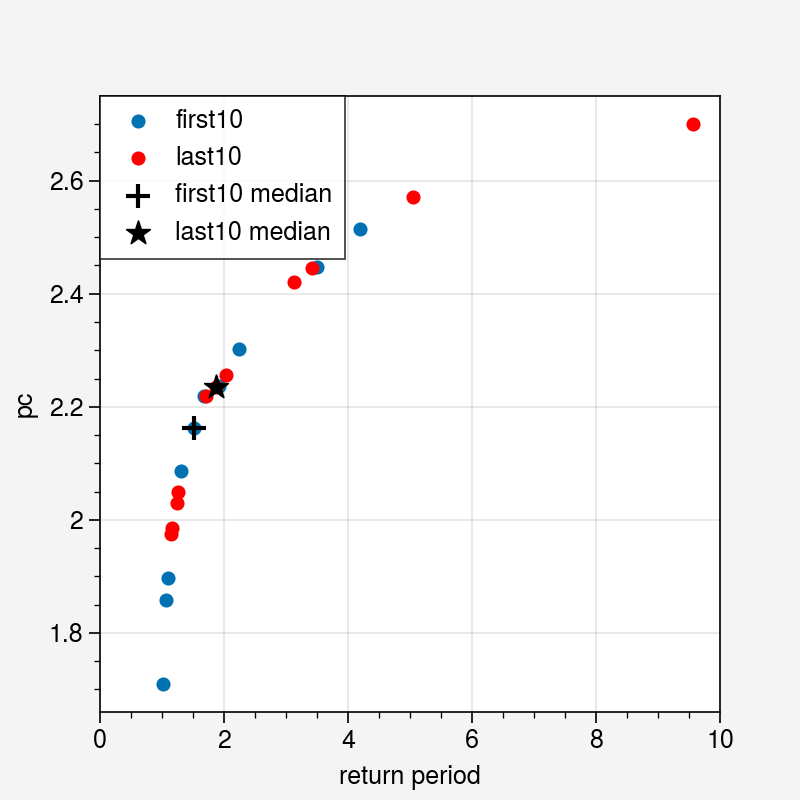

In [179]:
ax = plt.subplot()
first10_all_pos.sort_values("return period", ascending=False).plot(x = 'return period',y = 'pc',kind = 'scatter',ax = ax,label = 'first10')
last10_all_pos.sort_values("return period", ascending=False).plot(x = 'return period',y = 'pc',kind = 'scatter',ax = ax,label = 'last10',color = 'r')

# median
first10_median_pos.plot(x = 'return period',y = 'pc',kind = 'scatter',ax = ax,marker = '+',color = 'k',s = 80,label = 'first10 median')
last10_median_pos.plot(x = 'return period',y = 'pc',kind = 'scatter',ax = ax,marker = '*',color = 'k',s = 80,label = 'last10 median')
ax.set_xlim(0,10)


### negative

In [170]:
all_neg_extreme = NAO.min(dim = 'ens').to_dataframe()['pc']

In [171]:
all_return_neg = get_return_periods(
    ts=all_neg_extreme,
    extremes=all_neg_extreme,
    extremes_method="BM",
    extremes_type="low",
    block_size="365.2425D",
    return_period_size="365.2425D",
    plotting_position="cunnane",
)

In [172]:
first10_all_neg = all_return_neg.loc['1850':'1860']
last10_all_neg = all_return_neg.loc['1989':'1999']

In [175]:
first10_median_neg = median_return_period(first10_all_neg,method = 'min')
last10_median_neg = median_return_period(last10_all_neg,method = 'min')

(0.0, 10.0)

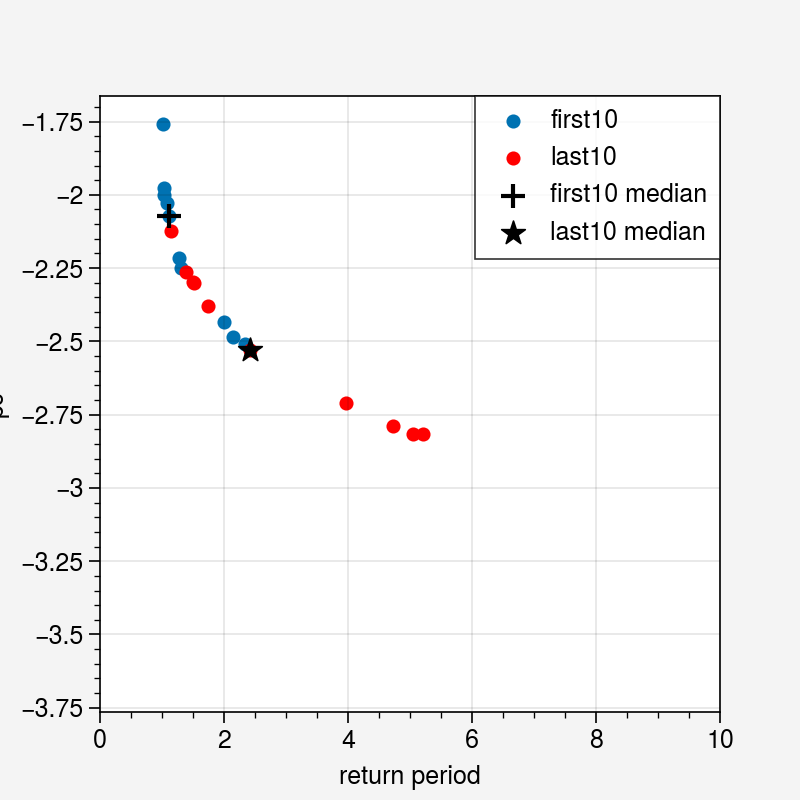

In [180]:
ax = plt.subplot()
first10_all_neg.sort_values("return period", ascending=False).plot(x = 'return period',y = 'pc',kind = 'scatter',ax = ax,label = 'first10')
last10_all_neg.sort_values("return period", ascending=False).plot(x = 'return period',y = 'pc',kind = 'scatter',ax = ax,label = 'last10',color = 'r')

# median
first10_median_neg.plot(x = 'return period',y = 'pc',kind = 'scatter',ax = ax,marker = '+',color = 'k',s = 80,label = 'first10 median')
last10_median_neg.plot(x = 'return period',y = 'pc',kind = 'scatter',ax = ax,marker = '*',color = 'k',s = 80,label = 'last10 median')
ax.set_xlim(0,10)

# ALL with class